<a href="https://colab.research.google.com/github/tirals88/Deep-Learning/blob/main/1%EA%B6%8C_4%EC%9E%A5_%EC%8B%A0%EA%B2%BD%EB%A7%9D_%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#드라이브연동
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd '/content/drive/My Drive/DLscratch/deep-learning-from-scratch/ch03'

/content/drive/My Drive/DLscratch/deep-learning-from-scratch/ch03


In [ ]:
import sys, os
sys.path.append(os.pardir)
from dataset.mnist import load_mnist

# 신경망 학습
---
1. 기계학습 문제는 데이터를 훈련 데이터와 시험 데이터로 나눠 학습과 실험을 수행하는 것이 일반적이다.
2. 딥러닝은 종단간 기계학습 end-to-end machine learning 이라고도 하며 이는 처음부터 끝까지 사람의 개입 없이 답을 도출해낸다는 것이다.
3. 데이터셋 하나로만 매개변수의 학습과 평가를 수행하면 올바른 평가가 될 수 없다. 한 데이터셋에만 지나치게 최적화된 상태를 **오버피팅**이라고 한다.

# 손실함수
---
가장 많이 쓰이는 손실함수는 평균 제곱 오차 'mean squared error, MSE'이다.

$$ E = \frac{1}{2}\sum_{k}(y_k - t_k)^2 $$

$y_k$는 신경망의 출력(신경망이 추정한 값), $t_k$는 정답 레이블, $k$는 데이터의 차원 수를 나타낸다.

In [ ]:
def mean_squared_error(y, t):
  return .5 * np.sum((y-t)**2)

In [ ]:
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] # 원-핫 인코딩

y = [.1, .05, .6, .0, .05, .1, .0, .1, .0, .0]
print(mean_squared_error(np.array(y), np.array(t)))

y2 = [.1, .05, .1, .0, .05, .1, .0, .6, .0, .0]
print(mean_squared_error(np.array(y2), np.array(t)))

0.09750000000000003
0.5975


또 다른 손실함수로서 **교차 엔트로피 오차 cross entropy error, CEE**도 자주 이용한다.
교차 엔트로피 오차의 수식은 다음과 같다.

$$ E = -\sum_{k} t_k\log(y_k) $$

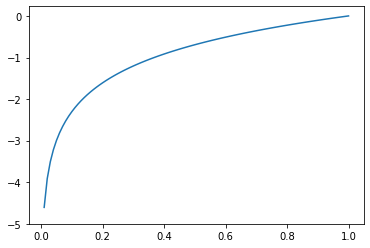

In [ ]:
def logx(x):
  return np.log(x)

x = np.arange(0.01, 1.01, .01)
y = logx(x)
plt.plot(x, y)
plt.ylim(-5.0, )
plt.show()

위의 $ y = \log(x) $ 그래프와 같이 정답에 해당하는 출력이 커질수록 0에 다가가다가, 그 출력이 1일 때 0이 된다.

반대로 정답일 때의 출력이 작아질수록 오차는 빠르게 커지게된다.

In [ ]:
def cross_entropy_error(y, t):
  delta = 1e-7                           # np.log() 함수에 0을 입력하면 마이너스 무한대를 뜻하는 -inf 가 출력되기 때문에 0이 되지 않도록 함
  return -np.sum(t * np.log(y + delta))

In [ ]:
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] # 원-핫 인코딩

y = [.1, .05, .6, .0, .05, .1, .0, .1, .0, .0]
print(cross_entropy_error(np.array(y), np.array(t)))

y2 = [.1, .05, .1, .0, .05, .1, .0, .6, .0, .0]
print(cross_entropy_error(np.array(y2), np.array(t)))

0.510825457099338
2.302584092994546


# 미니배치 학습
---
지금까지 데이터 하나에 대한 손실 함수만 생각해왔고, 훈련 데이터 모두에 대한 손실 함수의 합을 구하는 방법을 만들어본다.

$$ E = -\frac{1}{2}\sum_{n} \sum_{k} t_{nk} \log(y_{nk}) $$

데이터가 $N$개라면 $t_{nk}$는 $n$ 번째 데이터의 $k$번째 값을 의미한다.

---
MNIST 데이터셋만을 보더라도 훈련 데이터가 60,000개가 있다. 모든 데이터를 대상으로 손실 함수의 합을 구하려면 시간이 좀 걸리게 된다.

빅데이터 수준이 되면 그 수는 수백만에서 수천만도 넘는 거대한 값이 되기도 하므로 이 많은 데이터를 대상으로 일일이 손실 함수를 계산하는 것은 힘들다.

이런 경우 데이터의 일부를 추려 전체의 **'근사치'**로 이용할 수 있다. 훈련 데이터로부터 일부만 골라 학습을 수행한다.

이 때, 일부를 미니 배치 mini batch라고 한다.

In [ ]:
import os, sys
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = \
  load_mnist(normalize = True, one_hot_label = True)

print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


In [ ]:
print(x_train[0].shape)
print(x_train.shape[0])

(784,)
60000


In [ ]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)       # 0 ~ (train_size - 1) 까지의 숫자 중 무작위로 batch_size개를 뽑아냄
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

In [ ]:
x_batch.ndim

2

In [ ]:
# 배치용 교차 엔트로피 오차 구현
def cross_entropy_error(y, t):
  if y.ndim == 1:                 # y 가 1차원이라면 reshape를 통해 2차원으로 변형
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)
  batch_size = y.shape[0]
  return -np.sum( t * np.log(y + 1e-7)) / batch_size

In [ ]:
# 정답 레이블이 원-핫 인코딩이 아니라 '2' 나 '7' 등의 숫자 레이블로 주어졌을 경우

def cross_entropy_error(y, t):
  
  if y.ndim == 1:
    y = y.reshape(1, y.size)
    t = t.reshape(1, t.size)
  
  batch_size = y.shape[0]
  return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [ ]:
np.arange(1, 10)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
# np.log(y[np.arange(batch_size), t]) 예시

a = []
for i in range(10):
  b = []

  for j in range(10):
    b.append(str(i)+','+str(j))

  a.append(b)

a = np.array(a)           # 넘파이 배열로 변환
c = np.array([1,3,5,7,9])

print(a[np.arange(5) , c])

['0,1' '1,3' '2,5' '3,7' '4,9']


왜 손실함수를 사용해야하는가?

왜 정확도라는 지표를 놔두고 손실 함수의 값을 이용하는가?

이는 신경망 학습에서의 '미분'의 역할 때문이다.

1. 어떠한 가상의 신경망이 있고 그 신경망의 어느 한 가중치 매개변수에 주목한다고 하자.
2. 그 가중치 매개변수의 손실 함수의 미분이란 ; **가중치 매개변수의 값을 아주 조금 변화 시켰을 때, 손실 함수가 어떻게 변하나**라는 의미이다.
3. 이때 이 미분의 값이 음수이면, 가중치 매개변수를 양의 방향으로 변화시켜 손실 함수의 값을 줄일 수 있다. 반대의 상황에서는 음의 방향으로 변화시켜 손실 함수의 값을 줄일 수 있게 된다.
4. **그러나 미분 값이 0이면 가중치 매개변수를 어느 쪽으로 움직여도 손실 함수의 값은 달라지지 않는다. 그 때 가중치 매개변수의 갱신은 거기서 멈추게 된다.**

- 만약 정확도를 지표로 삼게 되면 대부분의 장소에서 미분 값이 0이 나오게 되어 갱신이 이루어지지 않기 때문이다.
---
그렇다면 정확도를 지표로 삼을 때 미분 값이 0이 나오는 이유는 무엇일까?

1. 이는 구체적인 예로 어떠한 신경망이 100장의 훈련 데이터 중 32장을 올바르게 인식한다고 하면 정확도는 32%가 나오게된다.
2. 가중치 매개변수의 값을 조금 바꾸더라도 정확도는 그대로 32%가 나오게 되는데 이는 약간 조정해서는 정확도가 32.0123%와 같은 값을 가질 수 없고, 33%, 34%와 같이 불연속적인 값으로 변화하기 떄문이다.
3. 그러나 이 경우에서도 손실 함수의 값은 연속적인 변화를 가지게 된다.

# 수치미분
---
미분은 한순간의 변화량을 표시한 것이다.

$$ \frac{df(x)}{dx}= \lim_{h\to0}\frac{f(x+h)-f(x)}{h} $$

In [ ]:
# 나쁜 구현 예
def numerical_diff(f, x):
  h = 10e-50
  return (f(x+h)-f(x))/h

- 위는 가급적 작은 값을 대입하고 싶었기에 $10e-50$ 이라는 작은 값을 이용하였지만, 이 방식은 **반올림 오차 rounding error**라는 문제를 일으킨다.
- 반올림 오차는 작은 값 ( 가령 소수점 8자리 이하 )이 생략되어 최종 계산 결과에 오차가 생기게 되는 것이다.

In [ ]:
print(np.float32(1e-50))
print(np.float32(1e-30))

0.0
1e-30


- float32 ( 32비트 부동소수점 ) 으로 나타내면 올바른 표현을 할 수가 없어진다.
- 여기서 첫번째 개선사항 : 미세한 값 h를 1e-50이 아닌 1e-4 ($10^{-4}$)로 하게 사용하게 되면 좋은 결과를 얻는다고 알려져 있다.
---
- 두번째 개선사항은 함수 f의 차분 ( 임의 두 점에서의 함수 값들의 차이 ) 과 관련되어있다.
- 앞선 함수에서는 ( $x+h$ ) 와 $x$ 사이의 함수 f의 차분을 계산하였다.
- 하지만 진정한 미분은 $x$ 위치에서의 기울기에 해당하지만 위 함수에서는 두 점사이의 기울기에 해당한다.
- 따라서 엄밀히는 미분과 구현의 값이 일치하지 않는다. 이 차이는 $h$ 가 무한히 0으로 좁힐 수 없는 것에 있다.